In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


def pre_processing(df_original, feature_scaling=True):
    #
    # only works for numerical dataframe
    #

    df = df_original.copy()
    df = df.drop(range(0, 10))
    df.index = range(len(df.index))

    df['month_year'] = [str(i[1]) + '-' + str(i[0]) for i in df['date'].astype(str).apply(lambda x: x.split('-'))]

    df = df.drop(['date'], axis=1)

    # handling the missing values
    ########################################################################
    # handle when number of records with missing values are less than 1%
    if (df.isna().sum().sum()) * 100 / len(df) < 1:
        df.dropna(axis=0)

    # handle when entries in column with missing values are less than 50%
    for i in range(len(df.isna().sum())):
        if (df.isna().sum()[i]) * 100 / len(df) > 50:
            df.drop(df.isna().sum().index[i], inplace=True, axis=1)

    # imputation using mean for numerical values
    num_cols = df._get_numeric_data().columns

    for i in range(len(df.isna().sum())):
        if df.isna().sum().index[i] in num_cols:
            df[df.isna().sum().index[i]].fillna(value=df[df.isna().sum().index[i]].mean(), inplace=True, axis=1)

    # return the updated dataframe

    # Feature scaling on numerical data
    ##########################################################################
    #
    if feature_scaling:
        for i in df.columns.tolist():
            if i != 'month_year':
                df[i] = df[i].apply(lambda x: (x - df[i].mean()) / df[i].std())

    return df


def merger(datalist, common_column="month_year", how_param="left", drop_na=True):
    data = datalist[0]
    for i in range(len(datalist) - 1):
        data = pd.merge(data, datalist[i + 1], on=common_column, how=how_param)
    if drop_na:
        data = data.dropna()
    data = data.reset_index()
    data = data.drop("index", axis=1)
    return data


def covNcorr(Mat):
    '''
    Data matrix is required in the columns as attributes(features) and rows as records
    '''
    Mat= Mat.astype(np.float)
    r,c= Mat.shape
    Colstd= np.zeros(c).astype(np.float)
    #print("shape of the given matrix is (r,c):", r,c)
    for i in range(c):
        Mat.iloc[:,i]= Mat.iloc[:,i]- np.mean(Mat.iloc[:,i])
    for i in range(c):
        Colstd[i]= 1/(r-1) * np.sqrt(np.dot(np.transpose(Mat.iloc[:,i]),Mat.iloc[:,i]))
    CovMat=np.zeros([c,c]).astype(np.float)
    CorrMat=np.zeros([c,c]).astype(np.float)
    for i in range(c):
        for j in range(c):
            CovMat[i][j]= 1/(r-1) * np.dot(np.transpose(Mat.iloc[:,i]),Mat.iloc[:,j])
            CorrMat[i][j]= 1/(r-1) * np.dot(np.transpose(Mat.iloc[:,i]),Mat.iloc[:,j]) / (Colstd[i]*Colstd[j])
    return CovMat, CorrMat

def PCA(Mat, IP=90, PCA_vectors=0, verbose = True):
    CovMat, CorrMat = covNcorr(Mat)
    
    if verbose:
        print('Correlation matrix\n###################################\n')
        print(CorrMat)
    
    e,v= np.linalg.eig(CovMat)
    df= pd.DataFrame([e,v]).transpose()
    df.columns=(["EigenValue","EigenVector"])
    dfsorted=df.sort_values(by= "EigenValue",ascending=False)
    eigenvalues_sorted= np.array(dfsorted["EigenValue"])
    eigenvectors_sorted= np.array(dfsorted["EigenVector"])

    sum_eigenvalues= np.sum(eigenvalues_sorted)
    eigen_temp_sum=0.0
    IP_calc= 0.0
    Transform_matrix= np.transpose(eigenvectors_sorted[0]).copy()
    i=0
    flag=1
    while flag:
        eigen_temp_sum= eigen_temp_sum+ eigenvalues_sorted[i]
        IP_calc= eigen_temp_sum/sum_eigenvalues *100
        if verbose:
            print("Adding Component No.", i+1)
        if i!=0:
            Transform_matrix = np.append(Transform_matrix,np.transpose(eigenvectors_sorted[i]))
        i=i+1
        if verbose:
            print("Information Retained = ", IP_calc)
        if PCA_vectors==0:
            if IP <= IP_calc or IP_calc==100:
                flag=0
        else:
            if i>=PCA_vectors or IP_calc==100:
                flag=0
    Ready_Transform_basis= np.transpose(Transform_matrix.reshape(i,eigenvectors_sorted[0].shape[0])).copy()
    if verbose:
        print(Ready_Transform_basis)
        print("Projected Data:")
    projected_data= np.dot(Mat,Ready_Transform_basis)
    if verbose:
        print(projected_data)

    information_Retained= IP_calc
   
    return Ready_Transform_basis, projected_data, information_Retained


def visualisatio_using_pca(features, target):
    
    Transformation_mat, projected_data, info_retainment = PCA(features,PCA_vectors=1, verbose=True)
    fig = plt.figure()
    fig.set_figwidth(16)
    fig.set_figheight(8)
    
    plt.scatter(projected_data, target, color = 'green')
    plt.title('Visualisation of variance on 1st Principle Component')
    plt.ylabel('GDP')
    plt.xlabel('1st PC projection')
    plt.legend([str(round(info_retainment,2))+"% information of actual data"])
    plt.show()


def polynomial_regressor_fit(X, y, degree=2):

    polynomial_model = PolynomialFeatures(degree=degree)
    transformed_X = polynomial_model.fit_transform(X)
    polynomial_model.fit(transformed_X, y)
    regressor = LinearRegression()
    regressor.fit(transformed_X, y)

    return regressor

In [ ]:
#
# Data laoding
#

df_cpi = pd.read_excel("data/CPI_base2015_1960_2020_Monthly.xls", names=['date', 'CPI_value'])
df_export_g_s = pd.read_excel("data/Export_G&S_1996_2020_quart.xls", names=['date', 'Export_g_s_value'])
df_GFCE = pd.read_excel("data/GFCE_1996_2020_quart.xls", names=['date', 'GFCE_value'])
df_GFCF = pd.read_excel("data/GFCF_1996_2020_quart.xls", names=['date', 'GFCF_value'])
df_GDP = pd.read_excel("data/GDP_india_1997_2021.xls", names=['date', 'GDP_value'])
df_M1 = pd.read_excel("data/M1_1969_2020_Monthly.xls", names=['date', 'M1_value'])
df_M3 = pd.read_excel("data/M3_1960_2020_Monthly.xls", names=['date', 'M3_value'])
df_PFCE = pd.read_excel("data/PFCE_1996_2020_quart.xls", names=['date', 'PFCE_value'])

In [ ]:
#
#  pre-processing
#

df_cpi = pre_processing(df_cpi)
df_export_g_s = pre_processing(df_export_g_s)
df_GFCE = pre_processing(df_GFCE)
df_GFCF = pre_processing(df_GFCF)
df_GDP = pre_processing(df_GDP, feature_scaling=False)
df_M1 = pre_processing(df_M1)
df_M3 = pre_processing(df_M3)
df_PFCE = pre_processing(df_PFCE)

In [ ]:
#
#  creating a common dataset
#

datalist = [df_cpi, df_export_g_s, df_GFCF, df_GFCE, df_M1, df_M3, df_PFCE, df_GDP]
data = merger(datalist)

In [ ]:
#
#  data preparation
#

gdp= data['GDP_value']
features = data.drop(['GDP_value','month_year'], axis = 1)

train_features, test_features, train_res, test_res= train_test_split(features,gdp)

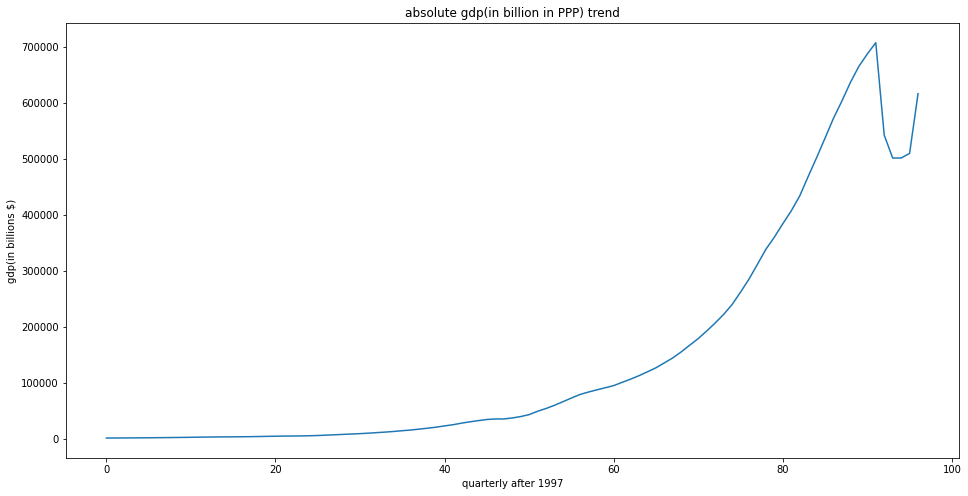

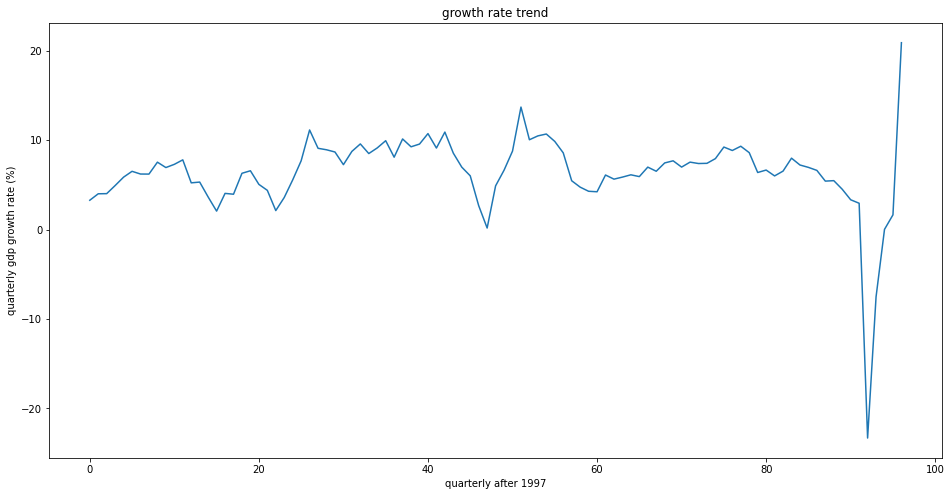

Correlation matrix
###################################

[[96.         94.69519048 94.02634858 93.11300277 94.13394016 95.46967909
  94.73984389]
 [94.69519048 96.         94.63996414 91.24132183 92.40635014 93.77695008
  93.48387539]
 [94.02634858 94.63996414 96.         90.62903855 92.45430605 93.54358302
  94.58431106]
 [93.11300277 91.24132183 90.62903855 96.         93.88820744 94.13129615
  92.94979704]
 [94.13394016 92.40635014 92.45430605 93.88820744 96.         95.35989723
  93.77826059]
 [95.46967909 93.77695008 93.54358302 94.13129615 95.35989723 96.
  95.038987  ]
 [94.73984389 93.48387539 94.58431106 92.94979704 93.77826059 95.038987
  96.        ]]
Adding Component No. 1
Information Retained =  97.98805504671397
[[ 0.32606044]
 [ 0.08344258]
 [-0.42604174]
 [-0.58868165]
 [ 0.56170125]
 [ 0.17581503]
 [-0.11065738]]
Projected Data:
[[0.76006031]
 [0.76098752]
 [0.75553652]
 [0.73370665]
 [0.73801201]
 [0.75453851]
 [0.78194453]
 [0.76873543]
 [0.74790065]
 [0.74810611]
 [0

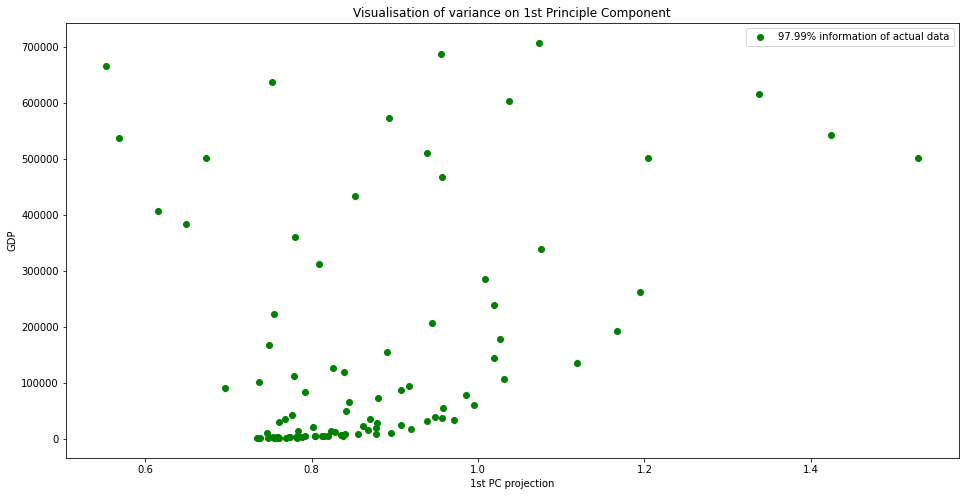

In [207]:
#
# Visualization of information in data
#

# calculation of absolute gdp after 19197 and its visulisation
gdp_actual_figure = 1653.1  # in billions$ in 1997 (PPP)
gdp_absolute = gdp.copy()

reference = gdp_actual_figure + gdp_actual_figure * gdp[0]/100

gdp_absolute[0] = reference

for i in range(len(gdp)-1):
    gdp_absolute[i+1] = reference + reference*gdp[i+1]/100
    reference = gdp_absolute[i+1]


fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(8)
plt.plot(gdp_absolute)
plt.title('absolute gdp(in billion in PPP) trend')
plt.xlabel('quarterly after 1997')
plt.ylabel('gdp(in billions $)')
plt.show()

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(8)
plt.plot(gdp)
plt.title('growth rate trend')
plt.xlabel('quarterly after 1997')
plt.ylabel('quarterly gdp growth rate (%)')
plt.show()


visualisatio_using_pca(features, gdp_absolute)

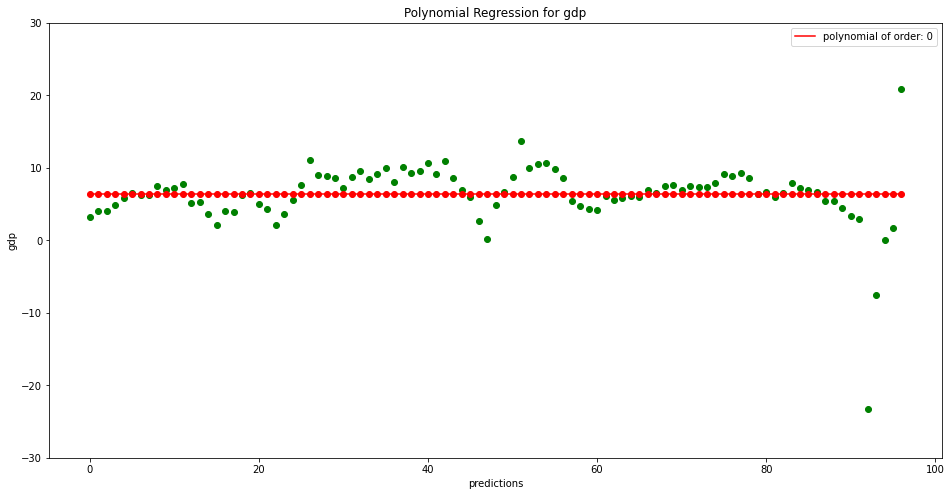

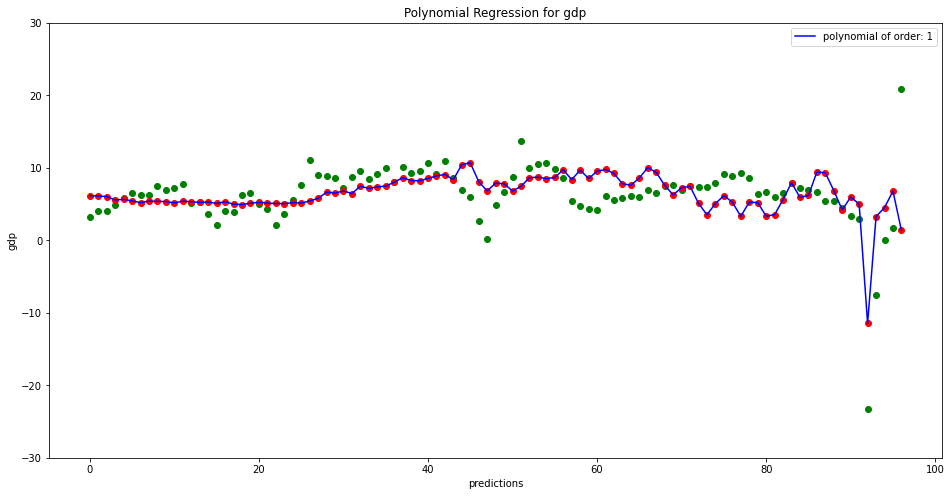

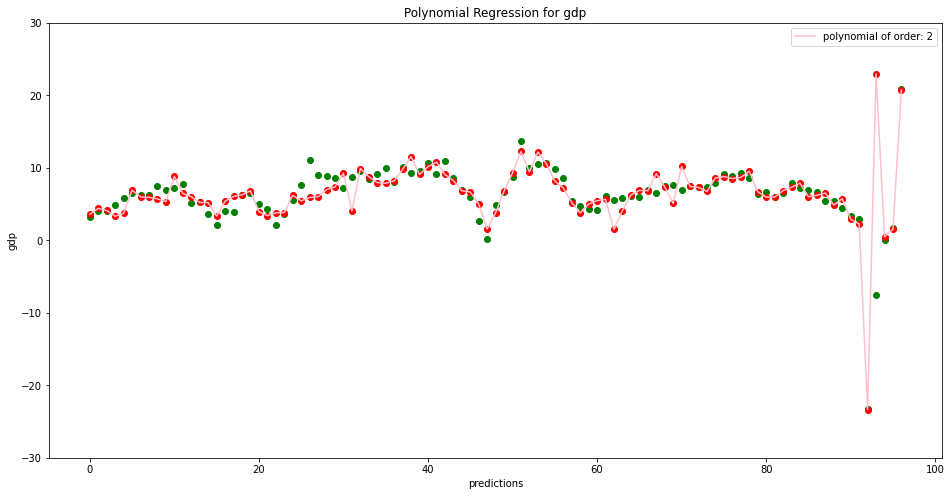

In [208]:
#
#  Modeling
#


colors = ['red', 'blue', 'pink', 'green', 'yellow']
for order in range(3):
    X = train_features
    y = train_res

    polynomial_model = PolynomialFeatures(degree=order)
    transformed_X = polynomial_model.fit_transform(X)
    polynomial_model.fit(transformed_X, y)
    regressor = LinearRegression()
    regressor.fit(transformed_X, y)

    output = regressor.predict(polynomial_model.fit_transform(features))

    x_axis = np.array([i for i in range(len(output))])

    
    fig = plt.figure()
    fig.set_figwidth(16)
    fig.set_figheight(8)
    plt.ylim([-30, 30])
    

    plt.scatter(x_axis, gdp, color = 'green')
    plt.scatter(x_axis, output, color = 'red')


    plt.plot(x_axis, regressor.predict(polynomial_model.fit_transform(features)), color = colors[order])
    
    plt.legend(['polynomial of order: '+ str(order)])

    plt.title('Polynomial Regression for gdp')
    plt.xlabel('predictions')
    plt.ylabel('gdp')
 
    plt.show()